# 7. Calibration of single ended measurement with WLS and confidence intervals

A single ended calibration is performed with weighted least squares. Over all timesteps simultaneous. $\gamma$ and $\alpha$ remain constant, while $C$ varies over time. The weights are not considered equal here. The weights kwadratically decrease with the signal strength of the measured Stokes and anti-Stokes signals.

The confidence intervals can be calculated as the weights are correctly defined.

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'single_ended')
timezone_netcdf = 'UTC'
timezone_ultima_xml = 'Europe/Amsterdam'
file_ext = '*.xml'

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf=timezone_netcdf,
    timezone_ultima_xml=timezone_ultima_xml,
    file_ext=file_ext)

ds = ds.sel(x=slice(-30, 101))  # only calibrate parts of the fiber
sections = {
            'probe1Temperature':    [slice(20, 25.5)],  # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
#             'referenceTemperature': [slice(-24., -4)]  # The internal coil is not so uniform
            }
ds.sections = sections

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended


In [3]:
print(ds.calibration_single_ended.__doc__)



        Parameters
        ----------
        sections : dict, optional
        st_label : str
            Label of the forward stokes measurement
        ast_label : str
            Label of the anti-Stoke measurement
        st_var : float, optional
            The variance of the measurement noise of the Stokes signals in the forward
            direction Required if method is wls.
        ast_var : float, optional
            The variance of the measurement noise of the anti-Stokes signals in the forward
            direction. Required if method is wls.
        store_c : str
            Label of where to store C
        store_gamma : str
            Label of where to store gamma
        store_dalpha : str
            Label of where to store dalpha; the spatial derivative  of alpha.
        store_alpha : str
            Label of where to store alpha; The integrated differential attenuation.
            alpha(x=0) = 0
        store_tmpf : str
            Label of where to store the

In [4]:
ds.data_vars

Data variables:
    ST                     (x, time) float64 6.267e+03 6.272e+03 ... 2.619e+03
    AST                    (x, time) float64 5.473e+03 5.473e+03 ... 2.09e+03
    TMP                    (x, time) float64 24.9 24.81 24.92 ... 10.63 10.71
    acquisitionTime        (time) float32 30.71 30.702 30.716
    referenceTemperature   (time) float32 24.5187 24.5168 24.5138
    probe1Temperature      (time) float32 18.0204 18.0211 18.0216
    probe2Temperature      (time) float32 6.61986 6.61692 6.61695
    referenceProbeVoltage  (time) float32 0.123199 0.123198 0.123198
    probe1Voltage          (time) float32 0.12 0.12 0.12
    probe2Voltage          (time) float32 0.115 0.115 0.115
    userAcquisitionTimeFW  (time) float32 30.0 30.0 30.0

In [5]:
st_label = 'ST'
ast_label = 'AST'

First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals.

In [6]:
st_var, resid = ds.variance_stokes(st_label=st_label, suppress_info=1)
ast_var, _ = ds.variance_stokes(st_label=ast_label, suppress_info=1)

Similar to the ols procedure, we make a single function call to calibrate the temperature. If the method is `wls` and confidence intervals are passed to `conf_ints`, confidence intervals calculated. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

The confidence intervals differ per time step. If you would like to calculate confidence intervals of all time steps together you have the option `ci_avg_time_flag=True`. 'We can say with 95% confidence that the temperature remained between this line and this line during the entire measurement period'.

In [7]:
ds.calibration_single_ended(sections=sections,
                           st_label=st_label,
                           ast_label=ast_label,
                           st_var=st_var,
                           ast_var=ast_var,
                           method='wls',
                           ci_avg_time_flag=0,
                           store_tempvar='_var',
                           conf_ints=[2.5, 50., 97.5],
                           solver='sparse',
                           store_p_cov='p_cov',
                           store_p_sol='p_val',
                           )

Lets compare our calibrated values with the device calibration

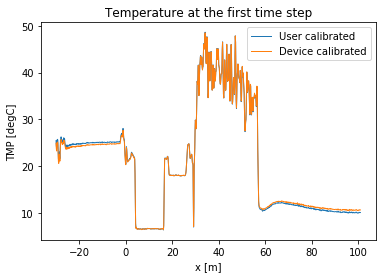

In [8]:
ds1 = ds.isel(time=0)  # take only the first timestep

ds1.TMPF.plot(linewidth=1, label='User calibrated')  # plot the temperature calibrated by us
ds1.TMP.plot(linewidth=1, label='Device calibrated')  # plot the temperature calibrated by the device
plt.title('Temperature at the first time step')
plt.legend();

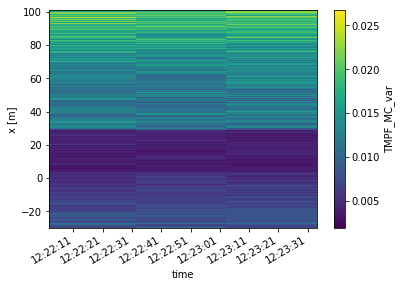

In [9]:
ds.TMPF_MC_var.plot();

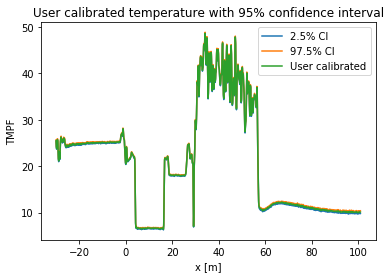

In [10]:
ds1.TMPF_MC.sel(CI=2.5).plot(label = '2.5% CI')
ds1.TMPF_MC.sel(CI=97.5).plot(label = '97.5% CI')
ds1.TMPF.plot(label='User calibrated')
plt.title('User calibrated temperature with 95% confidence interval')
plt.legend();

We can tell from the graph above that the 95% confidence interval widens furtherdown the cable. Lets have a look at the calculated variance along the cable for a single timestep. According to the device manufacturer this should be around 0.005929 degC.

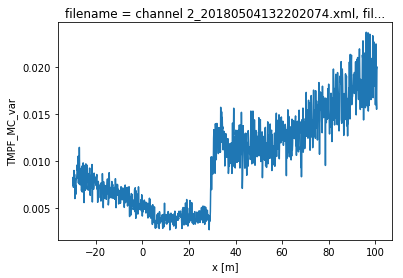

In [11]:
ds1.TMPF_MC_var.plot();

The variance of the temperature measurement appears to be larger than what the manufacturer reports. This is already the case for the internal cable; it is not caused by a dirty connector/bad splice on our side. Maybe the length of the calibration section was not sufficient.

At 30 m the variance sharply increases. There are several possible explanations. E.g., large temperatures or decreased signal strength.

Lets have a look at the Stokes and anti-Stokes signal.

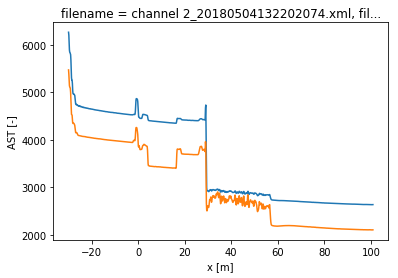

In [12]:
ds1.ST.plot()
ds1.AST.plot();

Clearly there was a bad splice at 30 m that resulted in the sharp increase of measurement uncertainty for the cable section after the bad splice.